<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Basic/Basic_nns_dls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLS Basic NNs tasks

## Imports

In [ ]:
!pip install -q --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import os
import random
import seaborn as sns
import torch
import wandb

from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

## Freeze seeds

In [ ]:
def seed_all(seed):
  random.seed(seed)
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True

In [ ]:
SEED = 42
seed_all(SEED)

# Part 1: Moons dataset

## Generate dataset

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

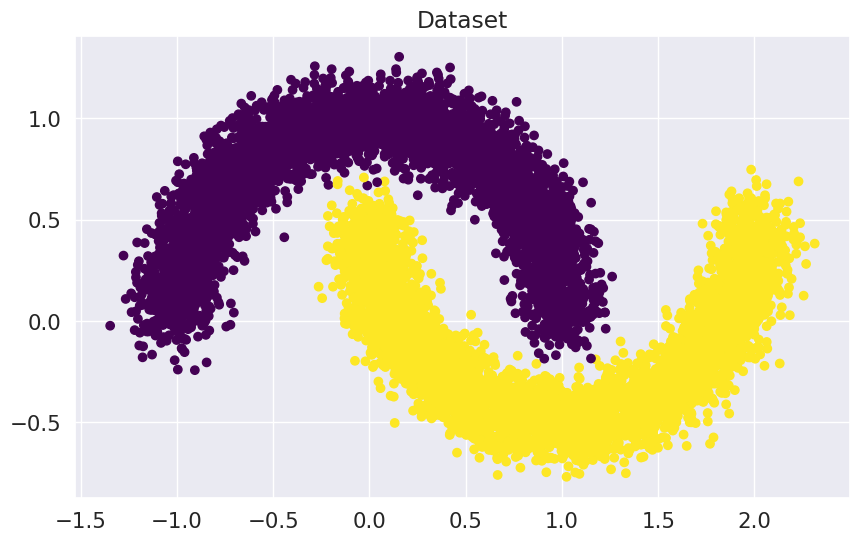

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

## Split data into train and val dfs

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Task 1: Create tensors converting them to torch.float32 and load using TensorDataset

In [ ]:
X_train_t =  torch.tensor(X_train, dtype=torch.float32)
y_train_t =  torch.tensor(y_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Implement Linear regression

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  x @ self.weights.T
        if self.bias:
            x +=  self.bias_term
        return x

In [ ]:
seed_all(SEED) #cos of manual seed
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

#### Question 1: How many trainable parameters are there in the class?

In [ ]:
result = sum([p.numel() for p in linear_regression.parameters() if p.requires_grad])
print(f'Answer: There are {result} trainable parameters')

Answer: There are 3 trainable parameters


Answer: the question is ambiguous. If bias is "True", there are two trainable parameters "weights" and "bias_term". Otherwise there is one - "weights".

### Task 2: Implement training cycle

In [ ]:
seed_all(SEED)
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch)
        loss = loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            iterations = {'iteration on batch':it,
                          'curr_epoch':epoch,
                          'batch_size':len(train_dataloader),
                          'total_iterations': it + epoch * len(train_dataloader)}
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5625
Iteration: 100
Batch accuracy: 0.796875
Iteration: 200
Batch accuracy: 0.8125
Iteration: 300
Batch accuracy: 0.8984375
Iteration: 400
Batch accuracy: 0.875
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125

Iteration: 755.Convergence. Stopping iterations.


#### Question 2: How many iteration is required to converge?

In [ ]:
#prev_iterations

{'iteration on batch': 51,
 'curr_epoch': 5,
 'batch_size': 59,
 'total_iterations': 346}

In [ ]:
iterations

{'iteration on batch': 47,
 'curr_epoch': 12,
 'batch_size': 59,
 'total_iterations': 755}

Answer: Depends on how the weights and biases (mostly weights)are initialized. Sometimes it takes over900, sometimes much less.
We need to set torch.manual_seed EVERY time again before we initialize the Model instance.
In previous case: 51 iterations with a batch size of 59 on the 5th epoch totalling to 346 iterations

With frozen seed 42 its 47 iterations (batch size 59) on 12 epochs, 755 iterations in total.

### Visualize

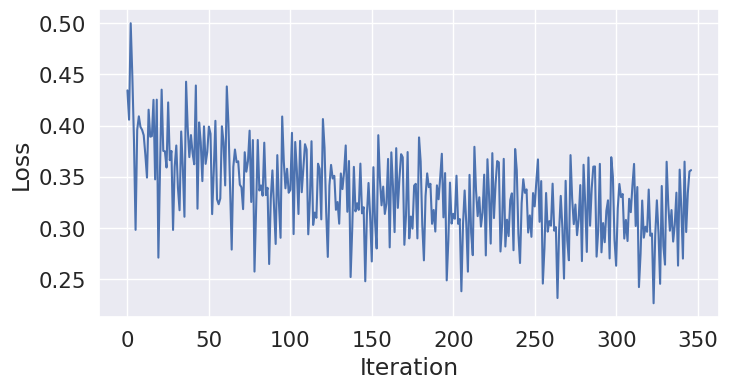

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

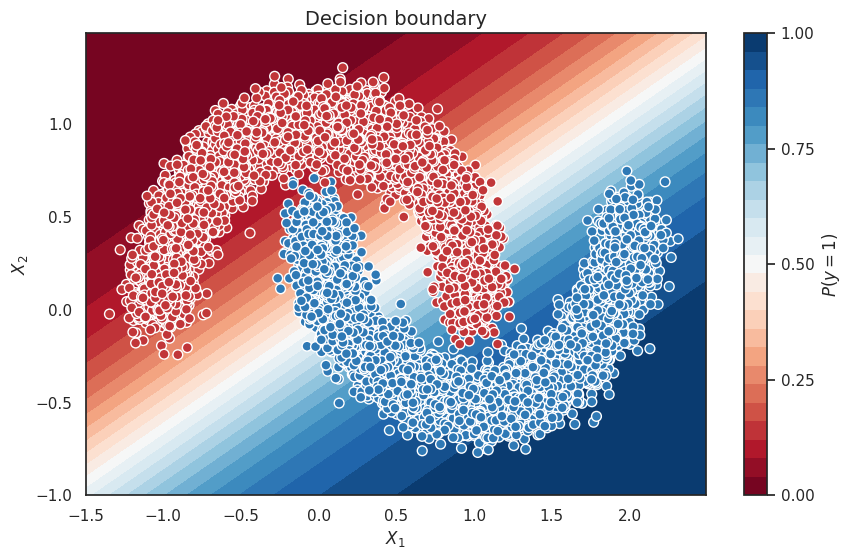

In [ ]:
sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Task 3: Implement predict function and calculate accuracy score on test

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = torch.sigmoid(model(x_batch))
        predictions = np.hstack((predictions, preds.numpy().flatten()))

    # Handle the incomplete batch since otherwise DataLoader would just create
    # additional rows mismathing dimensions
    if len(predictions) != len(dataloader.dataset):
        last_batch_size = len(dataloader.dataset) % dataloader.batch_size
        x_last_batch, _ = dataloader.dataset[-last_batch_size:]
        preds_last_batch = torch.sigmoid(model(x_last_batch))
        predictions = np.hstack((predictions, preds_last_batch.numpy().flatten()[:last_batch_size]))

    return predictions.flatten()[:len(dataloader.dataset)]


In [ ]:
val_predictions = predict(val_dataloader, linear_regression)
val_pred_labels = (val_predictions > 0.5).astype(int)
print(f'Accuracy: {accuracy_score(val_pred_labels, y_val_t)*100:.2f}%')

Accuracy: 85.44%


In [ ]:
report = classification_report(y_val_t, val_pred_labels)
print(report)

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86      1272
         1.0       0.85      0.85      0.85      1228

    accuracy                           0.85      2500
   macro avg       0.85      0.85      0.85      2500
weighted avg       0.85      0.85      0.85      2500



#### Question 3: What's the accuracy after training?

Answer: On this particular run, using that state of initalized weights, parameters it's 85.44%. Weighted average accuracy is 85% as well.

# Part 2: MNIST again

## Set up logging

In [ ]:
file_path = './wandb_api.txt'
WNB_PROJECT = 'torch_mnist'
WNB_LOGIN = 'dimildizio'

In [ ]:
if os.path.isfile(file_path):
  with open(file_path) as f:
    WANDB_API = f.readline()
    wandb.login(key=WANDB_API)
else:
  WANDB_API = False

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class CFG:
  train_batch = 64
  val_batch = 512
  n_in = 400      #linear
  n_out = 10
  lr = 0.15
  num_workers = 2
  n_epochs = 10
  seed = SEED
  mnist_mean = 0.1307
  mnist_std = 0.3081
  param_dict = {'epochs': n_epochs,
                'train_batch': train_batch,
                'num_workers': num_workers,
                'lr':lr,
                'seed':seed,
                'classes':n_out}
CFG.param_dict

{'epochs': 10,
 'train_batch': 64,
 'num_workers': 2,
 'lr': 0.15,
 'seed': 42,
 'classes': 10}

## Get the dataset

It' is worth noting that the right values to normalize MNIST dataset are not 0.5 and 0.5 but

MEAN: 0.1307

STD = 0.3081

In [ ]:
%%capture
data_tfs = tfs.Compose([tfs.ToTensor(),
                        tfs.Normalize(CFG.mnist_mean, CFG.mnist_std)])  #CFG.mnist_mean, CFG.mnist_std

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)


In [ ]:
train_dataloader =  DataLoader(train_dataset, batch_size=CFG.train_batch, shuffle=True,
                               pin_memory=True, num_workers=CFG.num_workers)
valid_dataloader =  DataLoader(val_dataset, batch_size=CFG.val_batch, shuffle=False,
                               pin_memory=True, num_workers=CFG.num_workers)

### Look at the **data**

In [ ]:
print('Train:', train_dataloader.dataset.data.shape)
print('Test:', valid_dataloader.dataset.data.shape)

Train: torch.Size([60000, 28, 28])
Test: torch.Size([10000, 28, 28])


In [ ]:
for data in train_dataloader:
    print('Datalength:', len(data))
    print('Images:', data[0].shape)
    print('Labels:', data[1].shape)
    break
print(f'Batches: {len(train_dataloader)}\nBatchsize:{CFG.train_batch}')

Datalength: 2
Images: torch.Size([64, 1, 28, 28])
Labels: torch.Size([64])
Batches: 938
Batchsize:64


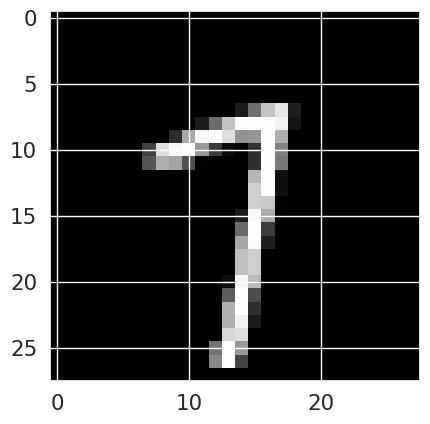

In [ ]:
img=train_dataloader.dataset.data[SEED].numpy()
plt.imshow(img, cmap='gray')
plt.show()

## Part 2.1 FC

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Task 4: Simple FC MLP

Initialize the model

In [ ]:
seed_all(CFG.seed)
activation = nn.ELU()
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
loaders = {"train": train_dataloader, "val": valid_dataloader}

### Task 5: complete the training cycle

In [ ]:
accuracy = {'train': [], 'val': []}
for epoch in range(CFG.n_epochs):
  print(f'Epoch: {epoch+1}')
  for name, dataloader in loaders.items():
    epoch_correct = 0
    epoch_all = 0

    for X_batch, y_batch in dataloader:
      if name == 'train':
        model.train()
        optimizer.zero_grad()
        output = model.forward(X_batch)

      else:
        model.eval()
        with torch.no_grad():
          output = model.forward(X_batch)

      y_pred = output.argmax(-1)
      epoch_correct += (y_pred == y_batch).sum().item()
      epoch_all += y_batch.size(0)

      if name == 'train':
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    acc = epoch_correct /epoch_all*100
    print(f'Loader: {name}. Accuracy: {acc:.2f}%')
    accuracy[name].append(acc)

Epoch: 1
Loader: train. Accuracy: 90.45%
Loader: val. Accuracy: 95.33%
Epoch: 2
Loader: train. Accuracy: 95.45%
Loader: val. Accuracy: 96.11%
Epoch: 3
Loader: train. Accuracy: 96.75%
Loader: val. Accuracy: 96.77%
Epoch: 4
Loader: train. Accuracy: 97.29%
Loader: val. Accuracy: 97.14%
Epoch: 5
Loader: train. Accuracy: 97.70%
Loader: val. Accuracy: 97.03%
Epoch: 6
Loader: train. Accuracy: 98.02%
Loader: val. Accuracy: 97.84%
Epoch: 7
Loader: train. Accuracy: 98.19%
Loader: val. Accuracy: 97.30%
Epoch: 8
Loader: train. Accuracy: 98.40%
Loader: val. Accuracy: 97.61%
Epoch: 9
Loader: train. Accuracy: 98.58%
Loader: val. Accuracy: 97.76%
Epoch: 10
Loader: train. Accuracy: 98.73%
Loader: val. Accuracy: 97.46%


### Task 6: Test different activation functions

In [ ]:
elu_accuracy = accuracy["val"]
[str(round(x, 2))+'%' for x in elu_accuracy]

['95.33%',
 '96.11%',
 '96.77%',
 '97.14%',
 '97.03%',
 '97.84%',
 '97.3%',
 '97.61%',
 '97.76%',
 '97.46%']

In [ ]:
def test_activation_function(activation):
  seed_all(CFG.seed)
  activation = activation()
  model = create_model(activation)
  optimizer = torch.optim.AdamW(model.parameters())
  criterion = nn.CrossEntropyLoss()
  val_acc = train_model(model, optimizer, criterion)
  print(f'{str(activation)}: {[str(round(valval, 2))+"%" for valval in val_acc]}')
  return val_acc

def create_model(activation):
  model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10))
  return model

def train_model(model, optimizer, criterion, loaders=loaders):
  accuracy = {'train': [], 'val': []}
  for epoch in range(CFG.n_epochs):
    for name, dataloader in loaders.items():
      epoch_correct = 0
      epoch_all = 0

      for X_batch, y_batch in dataloader:
        if name == 'train':
          model.train()
          optimizer.zero_grad()
        else:
          model.eval()

        output = model.forward(X_batch)

        y_pred = output.argmax(-1)
        epoch_correct += (y_pred == y_batch).sum().item()
        epoch_all += y_batch.size(0)

        if name == 'train':
          loss = criterion(output, y_batch)
          loss.backward()
          optimizer.step()

      acc = epoch_correct /epoch_all*100
      accuracy[name].append(acc)
  return accuracy['val']

In [ ]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Identical(): ['89.9%', '90.95%', '88.0%', '90.82%', '91.26%', '91.05%', '91.51%', '91.12%', '91.19%', '91.6%']
ReLU(): ['93.41%', '95.46%', '95.69%', '96.57%', '96.01%', '95.24%', '95.53%', '96.53%', '97.36%', '97.29%']
LeakyReLU(negative_slope=0.01): ['94.52%', '95.52%', '96.71%', '96.58%', '96.73%', '97.36%', '97.32%', '97.66%', '97.62%', '97.45%']


In [ ]:
mean = lambda x: round(sum(x)/len(x),2)
maxx = lambda x: round(max(x), 2)
means = {'no activation': mean(plain_accuracy),
         'relu': mean(relu_accuracy),
         'leaky relu': mean(leaky_relu_accuracy),
         'elu': mean(elu_accuracy)}
maxes  = {'no activation': maxx(plain_accuracy),
         'relu': maxx(relu_accuracy),
         'leaky relu': maxx(leaky_relu_accuracy),
         'elu': maxx(elu_accuracy)}

#### Accuracy on graph

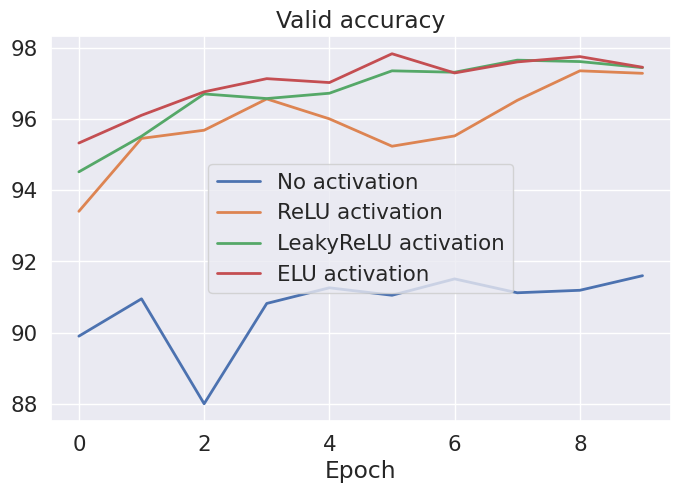

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)
max_epochs= CFG.n_epochs
plt.figure(figsize=(8, 5))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

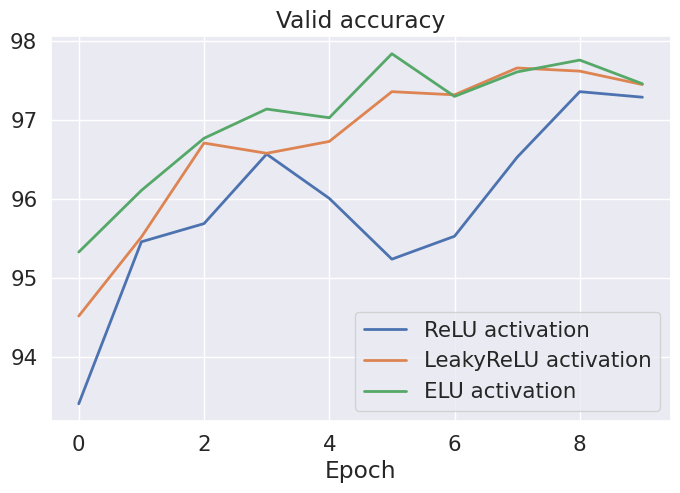

In [ ]:
plt.figure(figsize=(8, 5))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

#### Question 4: Which activation func has shown the best accuracy score?

In [ ]:
print('Means:', means)
print('Best scores:', maxes)

Means: {'no activation': 90.74, 'relu': 95.91, 'leaky relu': 96.75, 'elu': 97.03}
Best scores: {'no activation': 91.6, 'relu': 97.36, 'leaky relu': 97.66, 'elu': 97.84}


Answer: In these particular run, task and case - ELU (But, say we take 5 epochs, which doesn't really make a lot of difference and leaky ReLU or even ReLU could take the lead, the difference is that small)

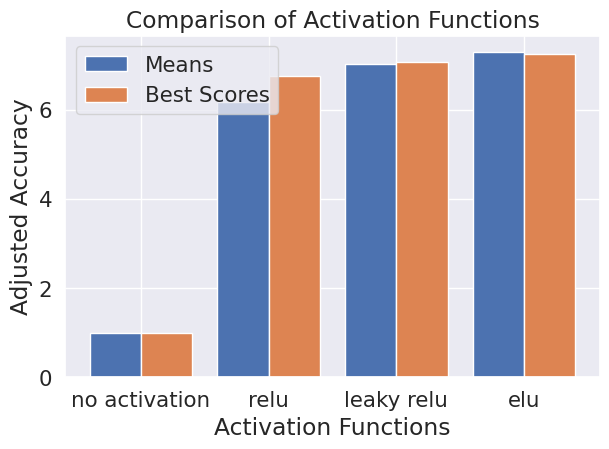

In [ ]:
def adjust(idict):
  vals = list(idict.values())
  return [x-min(vals)+1 for x in vals]

activation_functions = list(means.keys())
mean_values = adjust(means)
max_values = adjust(maxes)

fig, ax = plt.subplots()

bar_width = 0.4
index = range(len(activation_functions))

bar1 = plt.bar(index, mean_values, bar_width, label='Means')
bar2 = plt.bar([p + bar_width for p in index], max_values, bar_width, label='Best Scores')

plt.xlabel('Activation Functions')
plt.ylabel('Adjusted Accuracy')
plt.title('Comparison of Activation Functions')
plt.xticks([p + bar_width/2 for p in index], activation_functions)
plt.legend()

plt.tight_layout()
plt.show()

## Part 2.2 Convolutional Neural Networks

### Kernels

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-10-21 20:15:24--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   232KB/s    in 0.2s    

2023-10-21 20:15:25 (232 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



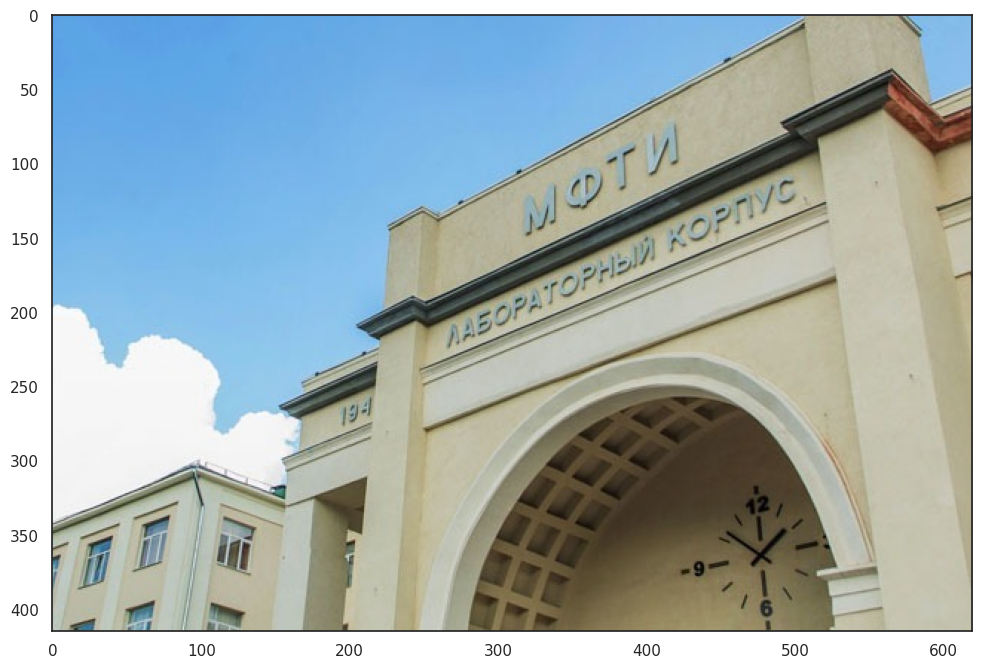

In [ ]:
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

In [ ]:
identity_kernel =  [[0, 0, 0],                    #А
                    [0, 1, 0],
                    [0, 0, 0]]

horizontal_sobel = [[0, 1, 0],                    #Б
                    [0, -2, 0],
                    [0, 1, 0]]

vertical_sobel =   [[0, 0, 0],                    #В
                    [1, -2, 1],
                    [0, 0, 0]]

cross_sobel =      [[0, 1, 0],                    #Г
                    [1, -4, 1],
                    [0, 1, 0]]

sharpen =          [[0, -1, 0],                   #Д
                    [-1, 5, -1],
                    [0, -1, 0]]

blur =             [[0.0625, 0.125, 0.0625],      #E
                    [0.125, 0.25, 0.125],
                    [0.0625, 0.125, 0.0625]]

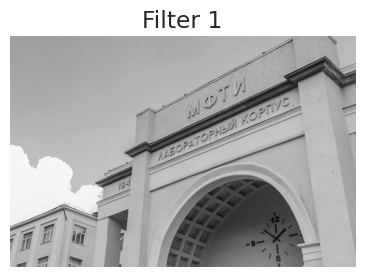

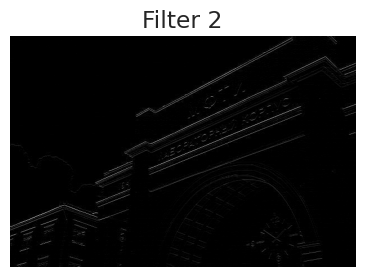

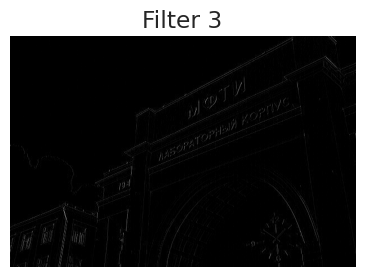

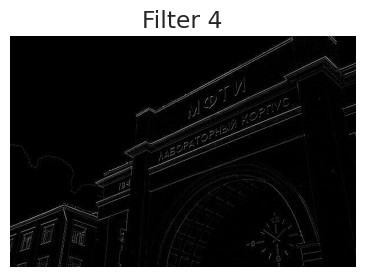

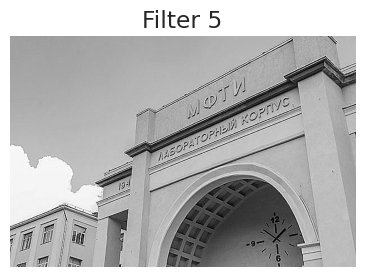

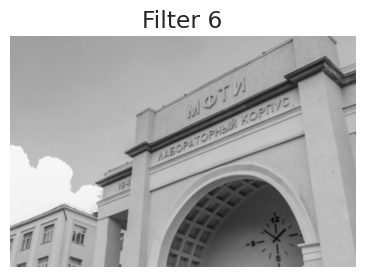

In [ ]:
kernels = [identity_kernel, vertical_sobel, horizontal_sobel, cross_sobel, sharpen, blur]

for i, kernel in enumerate(kernels):
    kernel = torch.tensor(kernel).reshape(1, 1, 3, 3).type(torch.float32)
    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    img_t = img_t.permute(0, 3, 1, 2)
    img_t = nn.ReflectionPad2d(1)(img_t)
    result = F.conv2d(img_t, kernel)[0]

    plt.figure(figsize=(5, 3))
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3
    plt.imshow(result_np)
    plt.axis('off')
    plt.title(f'Filter {i+1}')
    plt.show()

#### Question 5: How could one describe each kernel?

Answer:

1. blur - (filter 6) - E - размытие
2. sharpen - (filter 5) - Д - увеличение резкости
3. identity - (filter 1) - A - Тождественное преобразование
4. veritical_sobel - (filter 3) - Б - Выделение вертикальных границ
5. horizontal_sobel - (filter 2) - B - Выделение горизонтальных границ
6. cross_sobel - (filter 4) - Г - Выделение границ

### Task 7: Implement ResNet

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    #define activation functions
    self.act1 = nn.ReLU()
    self.act2 = nn.ReLU()
    self.act3 = nn.ReLU()
    self.act4 = nn.ReLU()

    # recall the convolution output size: (input - kernel_size + 2*padding) / stride +1
    # MNIST input size is 28x28 with 1 grey channel
    # output size of a convolution layer is (out_channels, dim, dim)
    # pooling downsamples the input by the kernel size

    # define convolutions
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)  # (28-3+2/0)/1+1=26 so (6, 26, 26)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3) #(13-3+2/0)/1+1=11 so (16, 11, 11)
    # define poolings
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # (6, 26, 26)->(6, 11, 11)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # (16, 12, 12) -> (16, 5, 5)
    # create one vector
    self.flatten = nn.Flatten()
    # define fcs
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

    #init weights
    nn.init.kaiming_normal_(self.conv1.weight)
    nn.init.kaiming_normal_(self.conv2.weight)
    nn.init.kaiming_normal_(self.fc1.weight)
    nn.init.kaiming_normal_(self.fc2.weight)
    nn.init.kaiming_normal_(self.fc3.weight)


  def forward(self, x):
    conv1 = self.act1(self.conv1(x))
    pool1 = self.pool1(conv1)

    conv2 = self.act2(self.conv2(pool1))
    pool2 = self.pool2(conv2)


    linear1 = self.act3(self.fc1(self.flatten(pool2)))
    linear2 = self.act4(self.fc2(linear1))
    linear3 = self.fc3(linear2)

    result = linear3
    return result

In [ ]:
seed_all(CFG.seed)
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [ ]:
loaders = {"Train": train_dataloader, "Test": valid_dataloader}

### Task 8: Train CNN

In [ ]:
def wandb_wrapper(func):
  def wrapped_func(*args, **kwargs):
    if WANDB_API:
      wandb.init(project=WNB_PROJECT, entity=WNB_LOGIN, config=CFG.param_dict)
      try:
        result = func(*args, **kwargs)
      finally:
        wandb.finish()
      return result
    else:
      return func(*args, **kwargs)
  return wrapped_func

In [ ]:
def cnn_trainer():
  seed_all(CFG.seed)
  model = LeNet().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters())
  return train_cnn(model, optimizer, criterion, loaders)


@wandb_wrapper
def train_cnn(model, optimizer, criterion, loaders=loaders):
  print('Starting training...')
  accuracy = {'Train': [], 'Test': []}
  best_val = 0.0
  best_wights = None

  for epoch in range(CFG.n_epochs):
    print(f'Epoch: {epoch+1}')

    for name, dataloader in loaders.items():
      epoch_correct = 0
      epoch_all = 0

      for X_batch, y_batch in dataloader:
        if name == 'Train':
          model.train()
          optimizer.zero_grad()
        else:
          model.eval()

        output = model.forward(X_batch)

        y_pred = output.argmax(-1)
        epoch_correct += (y_pred == y_batch).sum().item()
        epoch_all += y_batch.size(0)

        if name == 'Train':
          loss = criterion(output, y_batch)
          loss.backward()
          optimizer.step()

      acc = epoch_correct /epoch_all*100
      accuracy[name].append(acc)
      print(f'\t{name}: {acc:.2f}%')

      if WANDB_API:
        wandb.log({f'{name}_loss': loss.item(), f'{name}_accuracy': acc/100})

      if name == 'Test' and acc > best_val:
        best_val = acc
        best_weights = model.state_dict()

  if best_weights is not None:
    model.load_state_dict(best_weights)
  print('Training has finished')

  return accuracy

In [ ]:
CFG.param_dict['optim'] = 'AdamW'
CFG.param_dict['ConvKernels'] = '3x3'
CFG.param_dict['pooling'] = 'max2x2'
CFG.param_dict['Activation'] = 'ReLU'
CFG.param_dict['device'] = device
CFG.param_dict['lr'] = 'auto'
CFG.param_dict

{'epochs': 10,
 'train_batch': 64,
 'num_workers': 2,
 'lr': 'auto',
 'seed': 42,
 'classes': 10,
 'optim': 'AdamW',
 'ConvKernels': '3x3',
 'pooling': 'max2x2',
 'Activation': 'ReLU',
 'device': 'cpu'}

In [ ]:
lenet_acc_val = train_cnn(model, optimizer, criterion)
lenet_acc_val

[97.52,
 98.08,
 98.45,
 98.63,
 98.82,
 98.74000000000001,
 98.69,
 98.77,
 98.83999999999999,
 97.96000000000001]

In [ ]:
cnn_history = cnn_trainer()

Starting training...
Epoch: 1
	Train: 93.98%
	Test: 97.56%
Epoch: 2
	Train: 98.06%
	Test: 98.12%
Epoch: 3
	Train: 98.51%
	Test: 98.46%
Epoch: 4
	Train: 98.88%
	Test: 98.33%
Epoch: 5
	Train: 99.13%
	Test: 98.51%
Epoch: 6
	Train: 99.15%
	Test: 98.31%
Epoch: 7
	Train: 99.35%
	Test: 98.98%
Epoch: 8
	Train: 99.51%
	Test: 98.77%
Epoch: 9
	Train: 99.52%
	Test: 98.72%
Epoch: 10
	Train: 99.58%
	Test: 98.86%
Training has finished


Test_accuracy,▁▄▅▅▆▅█▇▇▇
Test_loss,▅▄█▃▁▁▁▁▁▂
Train_accuracy,▁▆▇▇▇▇████
Train_loss,▅▄█▃▁▁▁▁▁▂
Test_accuracy,0.9886
Test_loss,0.00679
Train_accuracy,0.99582
Train_loss,0.00679


3 epochs was enough

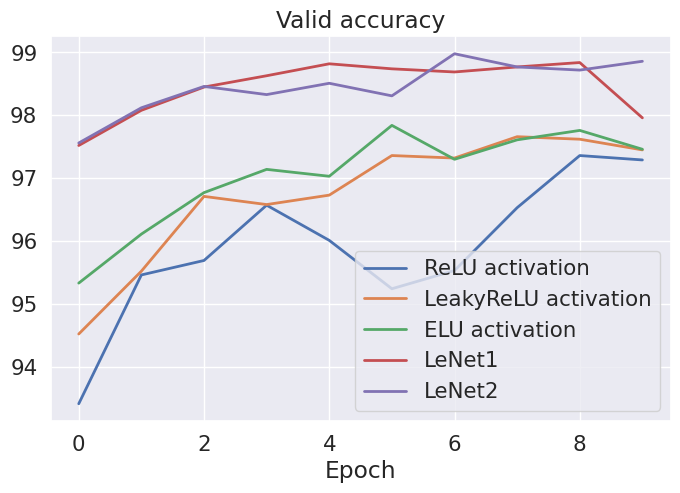

In [ ]:
cnn_val = cnn_history['Test']
max_epochs = CFG.n_epochs
plt.figure(figsize=(8, 5))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_acc_val, label="LeNet1", linewidth=2)
plt.plot(range(max_epochs), cnn_val, label="LeNet2", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
print(f"Train: {round(cnn_history['Train'][-1], 2)}%\nVal: {round(cnn_history['Test'][-1], 2)}%")

Train: 99.58%
Val: 98.86%


### Question 6: What accuracy do we get after training (round to 2 decimals)?

Answer: With given data, normalization, given hyperparameters and he-initialized weights: 99.58% on train, 98.86% on test